# 부스팅 기법

![nn](img/boost_model.png)

### 1. 데이터셋 

In [2]:
import pandas as pd

url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/wine.csv'

wine = pd.read_csv(url, index_col=0)
wine['taste'] = [1. if grade > 5 else 0. for grade in wine['quality']]

X = wine.drop(['taste', 'quality'], axis=1)
y = wine['taste']

### 2. scaler 적용

In [4]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_sc = sc.fit_transform(X)

### 3. split

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sc, y, test_size=0.2, random_state=13)

### 4. 앙상블 모델
- AdaBoostClassifier
- GradientBoostingClassifier
- RandomForestClassifier
- DecisionTreeClassifier
- LogisticRegression

In [7]:
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier, 
                             RandomForestClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


models = []
models.append(('AdaBoostClassifier', AdaBoostClassifier()))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier()))
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('LogisticRegression', LogisticRegression()))

#### 학습데이터의 정확도

In [11]:
from sklearn.model_selection import KFold, cross_val_score

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=5, random_state=13, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    
    print(name, cv_results.mean(), cv_results.std())

AdaBoostClassifier 0.7533103205745169 0.02644765901536818
GradientBoostingClassifier 0.7665884356259718 0.021614689094861146
RandomForestClassifier 0.8179679055304657 0.018197852028749375
DecisionTreeClassifier 0.7540849189309247 0.010796053900570705
LogisticRegression 0.74273191678389 0.015548839626296565


### 5.모델비교

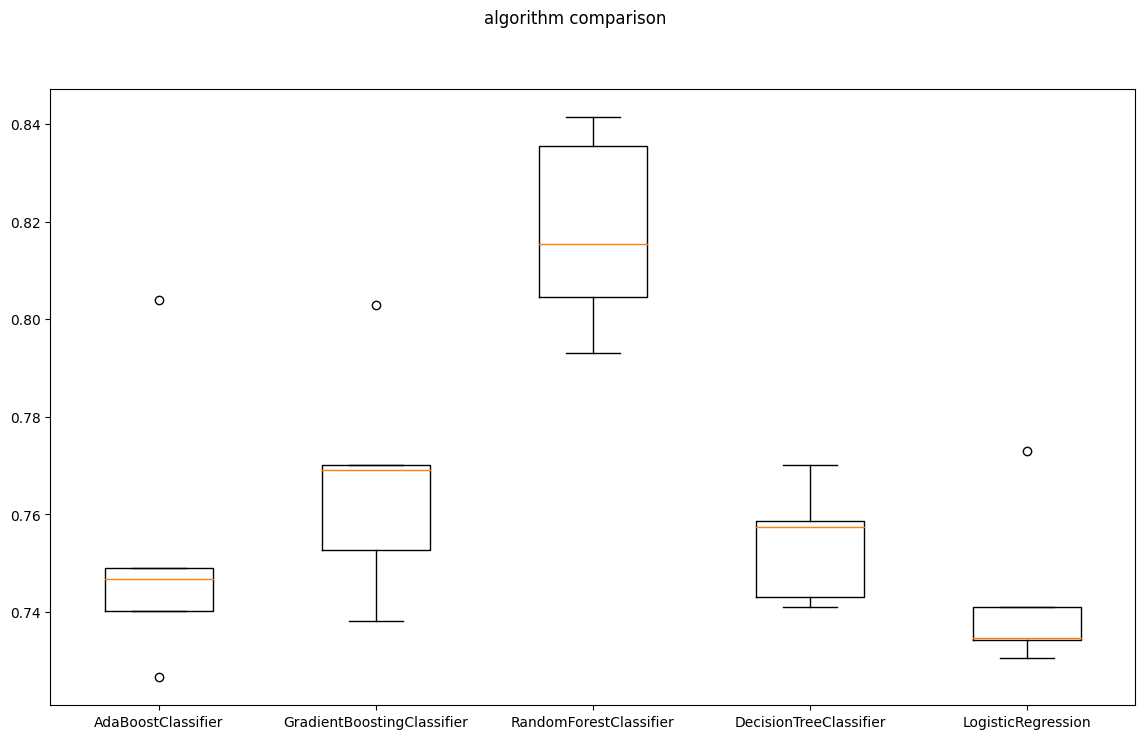

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14,8))
fig.suptitle('algorithm comparison')

ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### 6. 각 모델에 따른 테스트 데이터의 정확도

In [16]:
from sklearn.metrics import accuracy_score

for name, model in models:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    print(name, accuracy_score(y_test, pred))

AdaBoostClassifier 0.7553846153846154
GradientBoostingClassifier 0.7884615384615384
RandomForestClassifier 0.833076923076923
DecisionTreeClassifier 0.7738461538461539
LogisticRegression 0.7469230769230769


---

# GBM 모델
### 대용량 데이터셋 HAR 이용해서 실행시간 측정
- 부스팅 알고리즘은 여러 개의 약한 학습기(week learner)를 순차적으로 학습-예측하면서
- 잘못 예측한 데이터에 가중치를 부여해서 오류를 개선해가는 방식
- GBM은 가중치를 업데이트할 때 경사 하강법(Gradient Descent)을 이용하는 것이 큰 차이

#### 1. 데이터셋 불러오기

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/features.txt'
feature_name_df = pd.read_csv(url, sep='\s+', header=None, names=['column_index','column_name'])
feature_name = feature_name_df.iloc[:, 1].values.tolist()

feature_name_df.head()

,column_index,column_name
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y


In [20]:
X_train_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/train/X_train.txt'
X_test_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/test/X_test.txt'

X_train = pd.read_csv(X_train_url, sep='\s+', header=None)
X_test = pd.read_csv(X_test_url, sep='\s+', header=None)

X_train.columns = feature_name
X_test.columns = feature_name

In [21]:
y_train_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/train/y_train.txt'
y_test_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/test/y_test.txt'

y_train = pd.read_csv(y_train_url, sep='\s+', header=None, names=['action'])
y_test = pd.read_csv(y_test_url, sep='\s+', header=None, names=['action'])

#### 2. 실행시간 측정
- 1779 초 == 약 30분

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time
import warnings

warnings.filterwarnings('ignore')

In [23]:
start_time = time.time()
gb_clf = GradientBoostingClassifier(random_state=13)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)

print('ACC: ', accuracy_score(y_test, gb_pred))
print('Fit time: ', time.time() - start_time)

ACC:  0.9385816084153377
Fit time:  1779.8105509281158


#### 3. GridSearch 이용해 하이퍼파라미터 튜닝

In [26]:
from sklearn.model_selection import GridSearchCV

params = { 'n_estimators': [100, 500],
         'learning_rate': [0.05, 0.1]
         }

start_time = time.time()
grid = GridSearchCV(gb_clf, param_grid=params, cv=2, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)
print('Fit time: ', time.time() - start_time)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Fit time:  13584.597645759583


##### best parameter 찾음

In [ ]:
grid.best_score_

In [ ]:
grid.best_params_

In [ ]:
accuracy_score(y_test, grid.best_estimator_.predict(X_test))

---

# XGBoost 모델

- XGBoost는 트리 기반의 앙상블 학습에서 가장 각광받는 알고리즘 중 하나
- GBM 기반의 알고리즘인데, GBM의 느린 속도를 다양한 규제를 통해 해결
- 특히 병렬 학습이 가능하도록 설계됨
- XGBoost는 반복 수행 시마다 내부적으로 학습데이터와 검증데이터를 교차검증을 수행
- 교차검증을 통해 최적화되면 반복을 중단하는 조기 중단 기능을 가지고 있음

### 주요 파라미터
- nthread : CPU의 실행 스레드 개수를 조정. 디폴트는 CPU의 전체 스레드를 사용하는 것
- eta : GBM 학습률
- num_boost_rounds : n_estimators와 같은 파라미터
- max_depth

In [ ]:
pip install xgboost

In [ ]:
from xgboot import XGBClassifier
start_time = time.time()
xgb = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb.fit(X_train.values, y_train)
print('Fit time: ', time.time() - start_time)

In [ ]:
accuracy_score(y_test, grid.best_estimator_.predict(X_test.values))

#### 조기 종료 조건

In [ ]:
from xgboot import XGBClassifier
start_time = time.time()
xgb = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb.fit(X_train.values, y_train, early_stopping_rounds=10, eval_set=evals)
print('Fit time: ', time.time() - start_time)

In [ ]:
accuracy_score(y_test, grid.best_estimator_.predict(X_test.values))

---

# LightGBM

- LightGBM은 XGBoost와 함께 부스팅 계열에서 가장 각광받는 알고리즘
- LGBM의 큰 장점은 속도
- 단, 적은 수의 데이터에는 어울리지 않음 (일반적으로 10000건 이상의 데이터가 필요하다고 함)
- GPU 버전도 존재함

In [ ]:
pip install lightgbm

In [ ]:
from lightgbm import LGBMClassifier

start_time = time.time()
lgbm = LGBMClassifier(n_estimators=400)
lgbm.fit(X_train.values, y_train, early_stopping_rounds=10, eval_set=evals)
print('Fit time: ', time.time() - start_time)

In [ ]:
accuracy_score(y_test, grid.best_estimator_.predict(X_test.values))